<a href="https://colab.research.google.com/github/lindahnyambura/sound_clustering/blob/main/sound_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering Unlabeled Sound Data**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score

## **Data Loading and Feature Extraction**

In [3]:
# Load the data
data_path = '/content/drive/MyDrive/unlabelled_sounds/unlabelled_sounds'

# list all audio files
audio_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]
print(f"Found {len(audio_files)} audio files")

# load first file
y, sr = librosa.load(os.path.join(data_path, audio_files[0]))
print(f"Sample rate: {sr}, Duration: {len(y)/sr:.2f}s")

Found 3035 audio files
Sample rate: 22050, Duration: 0.36s


### **EDA**

In [ ]:
# comfirming all files are .wav
from collections import Counter

file_extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(data_path)]
ext_counts = Counter(file_extensions)

# Display counts
for ext, count in ext_counts.items():
    print(f"{ext}: {count} files")


.wav: 3035 files


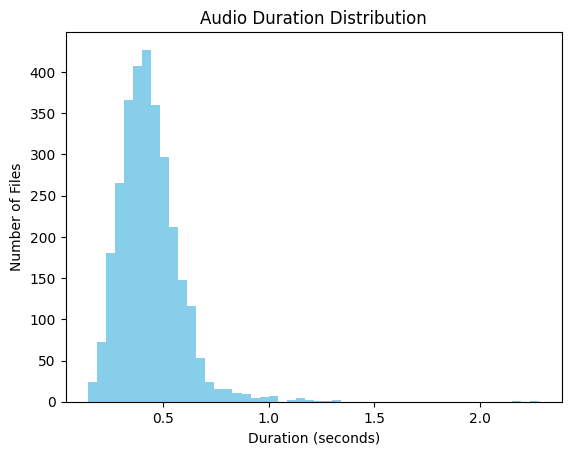

In [ ]:
# CHECK DURATION DISTRIBUTION FOR ALL CLIPS
durations = []
for f in audio_files:
    y, sr = librosa.load(os.path.join(data_path, f))
    durations.append(len(y) / sr)

import matplotlib.pyplot as plt
plt.hist(durations, bins=50, color='skyblue')
plt.title('Audio Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Files')
plt.show()

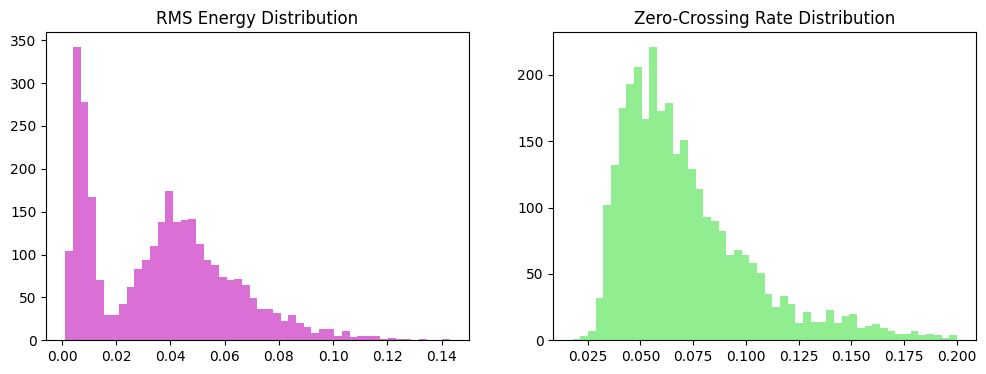

In [ ]:
# CHECK BASIC AMPLITUDE PROPERTIES
rms_values = []
zcr_values = []

for f in audio_files:
    y, _ = librosa.load(os.path.join(data_path, f))
    rms = np.mean(librosa.feature.rms(y=y))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    rms_values.append(rms)
    zcr_values.append(zcr)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.hist(rms_values, bins=50, color='orchid')
plt.title('RMS Energy Distribution')

plt.subplot(1, 2, 2)
plt.hist(zcr_values, bins=50, color='lightgreen')
plt.title('Zero-Crossing Rate Distribution')
plt.show()


### **Feature extraction (Mel Spectrogram)**

In [4]:
def extract_mel_features(file_path, n_mels=128):
    y, sr = librosa.load(file_path)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    # Convert to dB scale (log-mel)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    # Aggregate statistics over time
    mean_mel = np.mean(log_mel, axis=1)
    std_mel = np.std(log_mel, axis=1)
    return np.concatenate([mean_mel, std_mel])

# Extract features for all files
features = []
for file in tqdm(audio_files):
    file_path = os.path.join(data_path, file)
    features.append(extract_mel_features(file_path))

# Convert to DataFrame
feature_df = pd.DataFrame(features)
print(f"Extracted {feature_df.shape[1]} features for {feature_df.shape[0]} files.")

100%|██████████| 3035/3035 [01:30<00:00, 33.70it/s] 


Extracted 256 features for 3035 files.


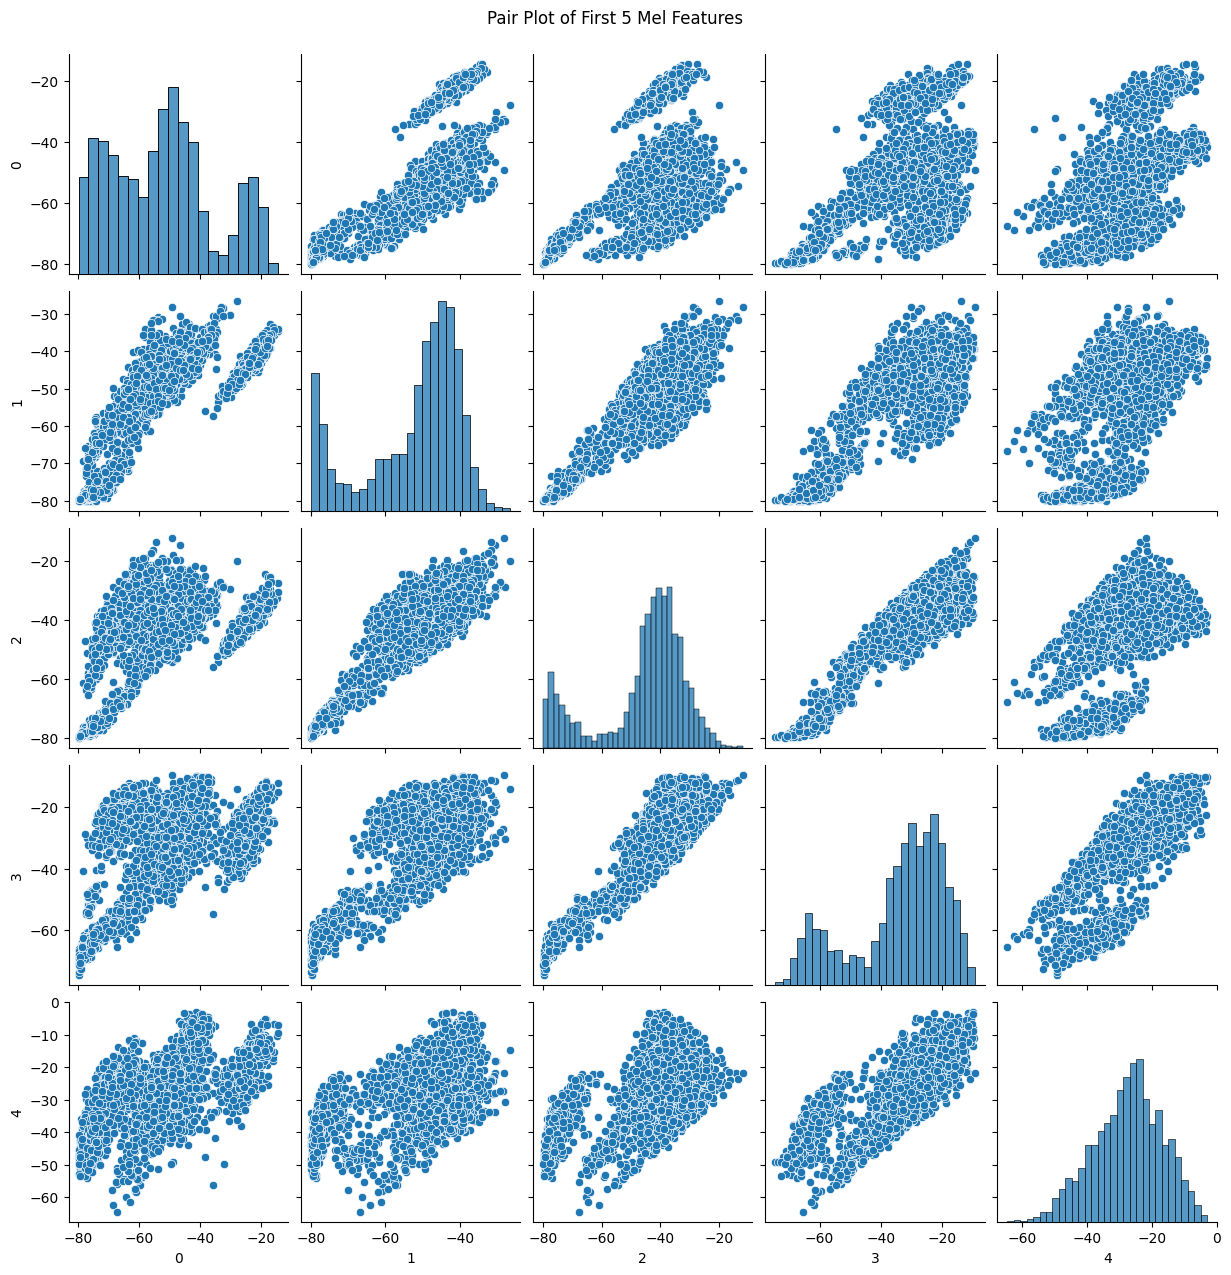

In [ ]:
# Pair plot of first 5 features
sns.pairplot(feature_df.iloc[:, :5])
plt.suptitle("Pair Plot of First 5 Mel Features", y=1.02)
plt.show()

### **Why is dimensionality reduction important?**

Although the Mel features extracted represent meaningful properties, we are dealing with 256-dimensional space. Visualizing this space directly is impossible, we can at least look at 2D or 3D projections at a time. So far we have only shown the first 5 features, but meaningful variation may be spread across many more dimensions.


**Without dimensionality reduction, we face several challenges:**

- overplotting: in 2D plots, overlapping points make it hard to assess separability between sound types.
- curse of dimensionality: as dimensions increase, distance metrics become less meaningful, Euclidean distances flatten out, making clustering unreliable.
- some features are highly correlated (as seen in diagonal trends), adding noise without new information

Dimensionality reduction helps us:

- Visualize high-dimensional data in 2D or 3D.
- Preserve structure that is most important for clustering.
- Reduce noise and redundancy, improving cluster compactness and interpretability.

## **Dimensionality Reduction: Applying PCA and t-SNE**

### **PCA**

In [5]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)

# Reduce to 3 components
pca = PCA(n_components=3)
pca_results = pca.fit_transform(scaled_features)

# Create a DF for plotting
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3'])
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Explained variance ratio: [0.39999485 0.19016439 0.10693245]


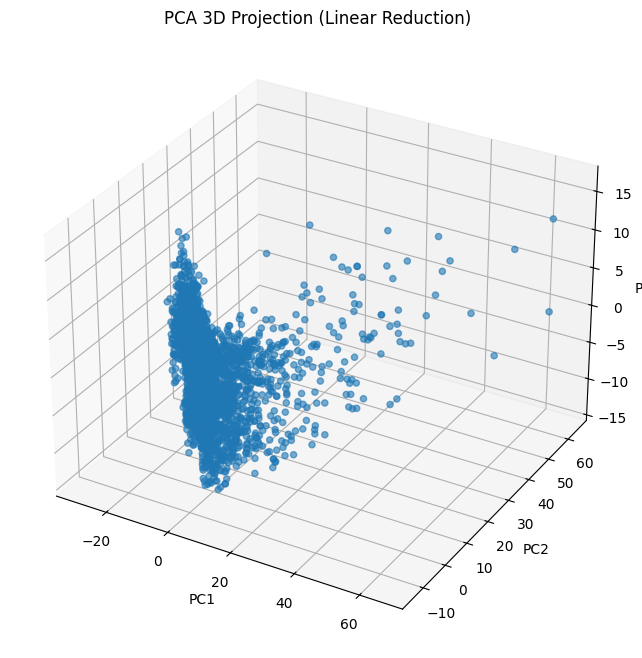

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], alpha=0.6)
ax.set_title("PCA 3D Projection (Linear Reduction)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

### **t-SNE**

In [7]:
# Reduce to 3 components
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)

# DF for plotting
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2', 'TSNE3'])

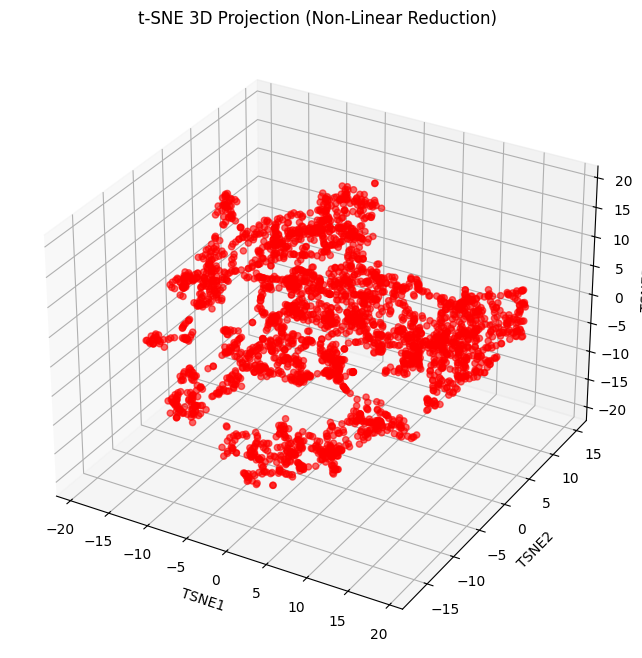

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['TSNE3'], alpha=0.6, c='red')
ax.set_title("t-SNE 3D Projection (Non-Linear Reduction)")
ax.set_xlabel("TSNE1")
ax.set_ylabel("TSNE2")
ax.set_zlabel("TSNE3")
plt.show()

### **Which method (PCA or t-SNE) provides better separability of clusters and why?**

**PCA**
- from the explained variance of the first 3 components, it shows that they explain about 70% of the total variance in the data
- from the plot observations, most data points are concentrated around a point, there is clearly no seperable structure or obvious clusters
- we can conclude that PCA assumes linear separability, which may not show complex nonlinear structures

**t-SNE**
- it reveals more seperated clusters, highlighting nonlinear boundaries PCA missed
- the dense groupings show that t-SNE is more effective for uncovering latent structure in sound data, making it a more suitable choice for visualizing potential clusters prior to applying clustering algorithms.

## **Clustering Sound Data**

### **With t-SNE**

### **K-Means**

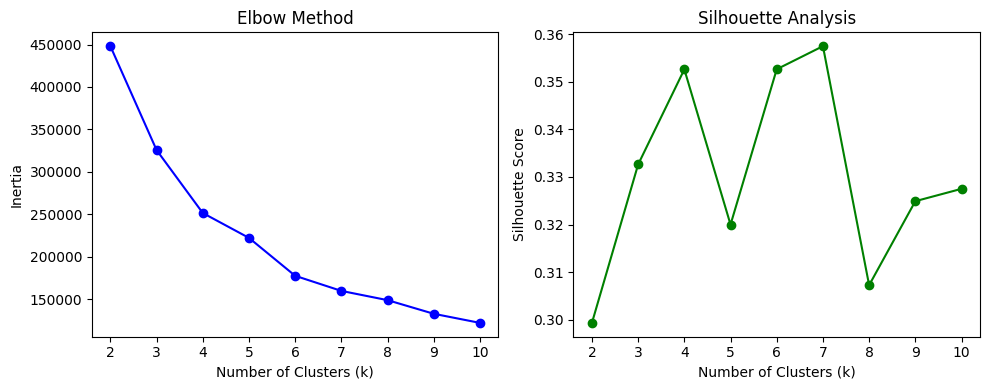

In [10]:
X = tsne_results

# Elbow Method (inertia)
inertias = []
silhouettes = []
k_range = range(2, 11)  # Test k from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, 'go-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.tight_layout()
plt.show()

In [14]:
for i, k in enumerate(k_range):
    print(f"k={k}: Inertia={inertias[i]:.2f}, Silhouette={silhouettes[i]:.3f}")


k=2: Inertia=448133.72, Silhouette=0.299
k=3: Inertia=325645.91, Silhouette=0.333
k=4: Inertia=251437.25, Silhouette=0.353
k=5: Inertia=222099.78, Silhouette=0.320
k=6: Inertia=177404.47, Silhouette=0.353
k=7: Inertia=159600.64, Silhouette=0.357
k=8: Inertia=148703.70, Silhouette=0.307
k=9: Inertia=132627.36, Silhouette=0.325
k=10: Inertia=121901.32, Silhouette=0.328


In [11]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Add labels to t-SNE DF for visualization
tsne_df['KMeans_Cluster'] = kmeans_labels

### **DBSCAN**

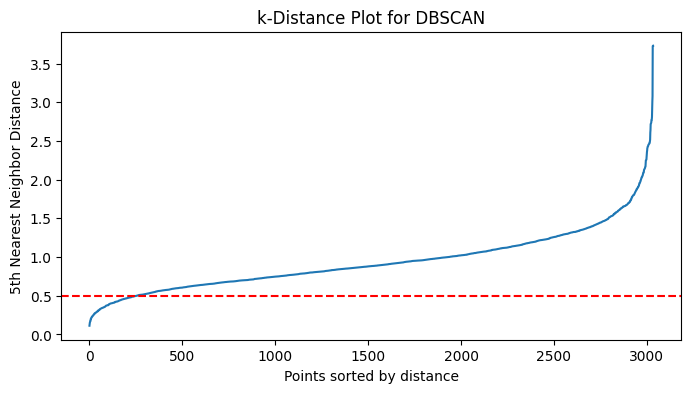

In [ ]:
# Find optimal eps using k-distance plot
nn = NearestNeighbors(n_neighbors=5).fit(X)
distances, _ = nn.kneighbors(X)
distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("k-Distance Plot for DBSCAN")
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

In [17]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Add labels to t-SNE DF
tsne_df['DBSCAN_Cluster'] = dbscan_labels
print(f"DBSCAN found {len(np.unique(dbscan_labels))} clusters (including noise).")

DBSCAN found 73 clusters (including noise).


tested different eps values:

0.5 - 73 clusters

0.8 - 193 clusters

1.0 - 168 clusters

1.5 - 67 clusters


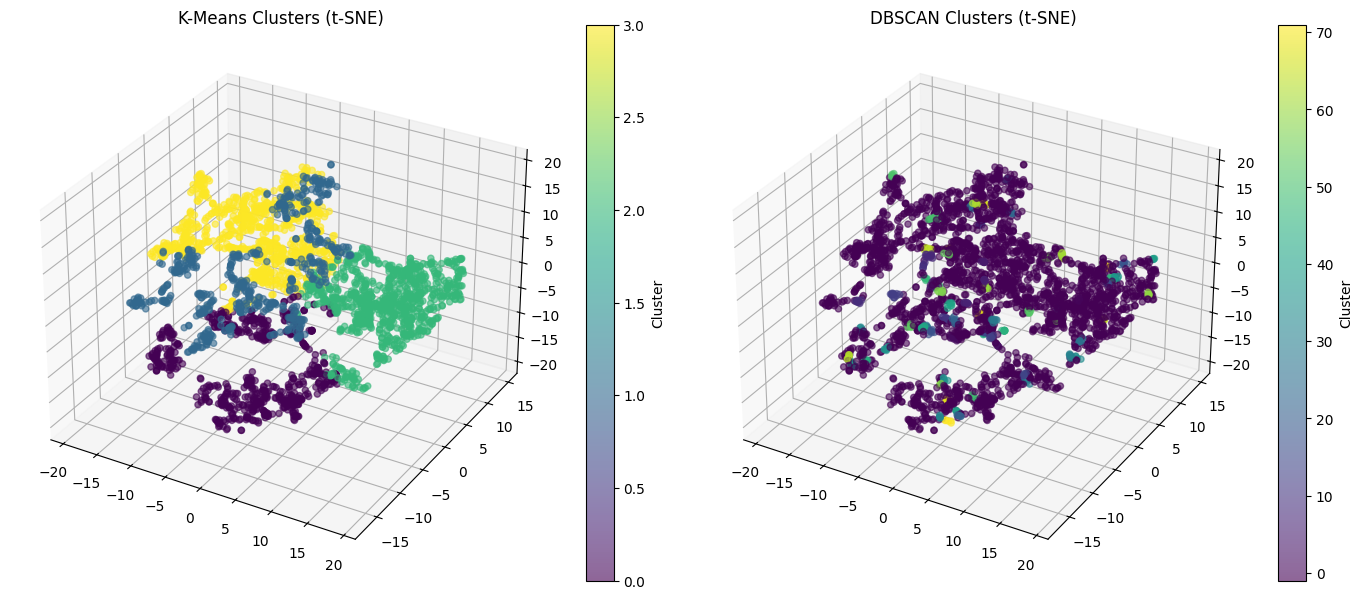

In [ ]:
# K-Means Clusters (t-SNE)
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['TSNE3'],
                      c=tsne_df['KMeans_Cluster'], cmap='viridis', alpha=0.6)
ax1.set_title("K-Means Clusters (t-SNE)")
fig.colorbar(scatter1, ax=ax1, label='Cluster')

# DBSCAN Clusters (t-SNE)
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['TSNE3'],
                      c=tsne_df['DBSCAN_Cluster'], cmap='viridis', alpha=0.6)
ax2.set_title("DBSCAN Clusters (t-SNE)")
fig.colorbar(scatter2, ax=ax2, label='Cluster')
plt.tight_layout()
plt.show()

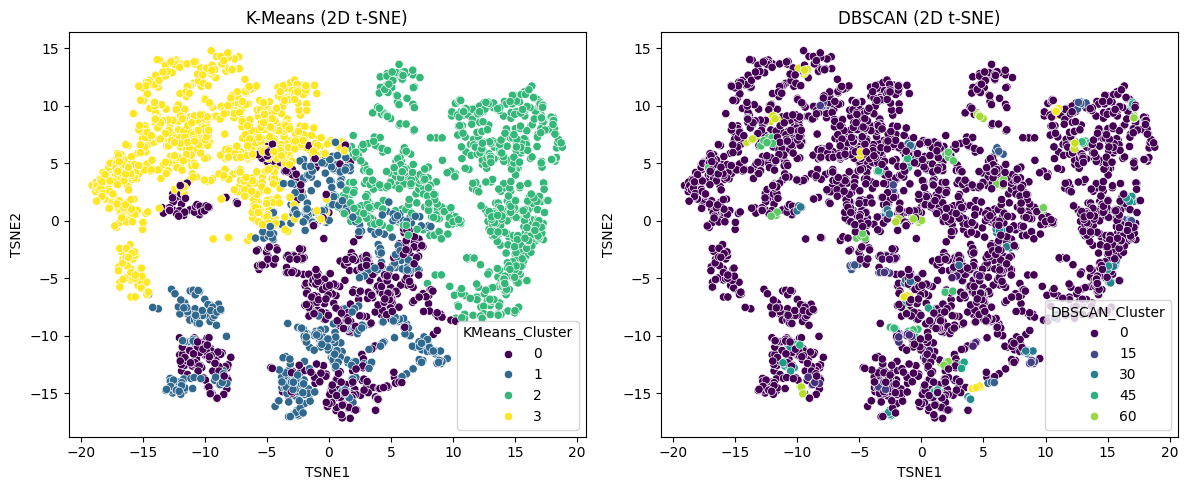

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='KMeans_Cluster', palette='viridis')
plt.title("K-Means (2D t-SNE)")

plt.subplot(1, 2, 2)
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='DBSCAN_Cluster', palette='viridis')
plt.title("DBSCAN (2D t-SNE)")
plt.tight_layout()
plt.show()

### **Evaluating clustering performance**

In [18]:
# K-Means Metrics
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_db = davies_bouldin_score(X, kmeans_labels)

# DBSCAN Metrics (ignore noise points)
valid_mask = dbscan_labels != -1  # Exclude noise (-1 labels)
if sum(valid_mask) > 1:
    dbscan_silhouette = silhouette_score(X[valid_mask], dbscan_labels[valid_mask])
    dbscan_db = davies_bouldin_score(X[valid_mask], dbscan_labels[valid_mask])
else:
    dbscan_silhouette = -1
    dbscan_db = -1

print("K-Means Metrics:")
print(f"- Inertia: {kmeans_inertia:.2f}")
print(f"- Silhouette Score: {kmeans_silhouette:.2f}")
print(f"- Davies-Bouldin Index: {kmeans_db:.2f}\n")

print("DBSCAN Metrics:")
print(f"- Silhouette Score: {dbscan_silhouette:.2f}")
print(f"- Davies-Bouldin Index: {dbscan_db:.2f}")
print(f"- Clusters found: {len(np.unique(dbscan_labels))} (Including noise)")

K-Means Metrics:
- Inertia: 251437.25
- Silhouette Score: 0.35
- Davies-Bouldin Index: 1.01

DBSCAN Metrics:
- Silhouette Score: 0.83
- Davies-Bouldin Index: 0.22
- Clusters found: 73 (Including noise)


### **With PCA**

### **K-Means**

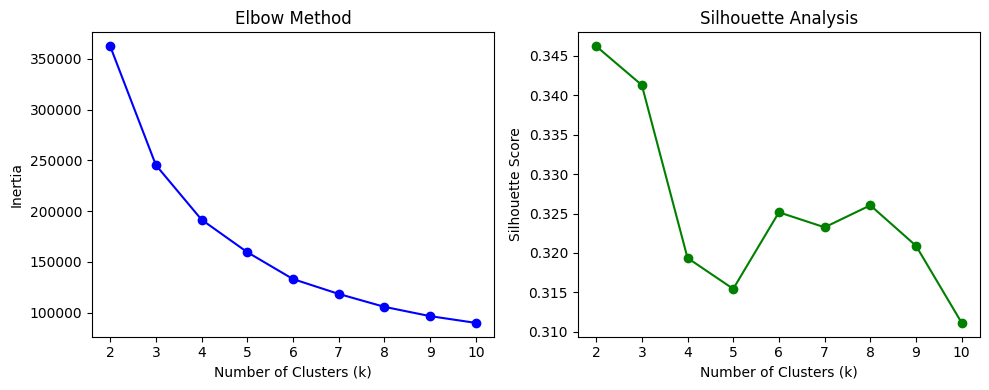

In [19]:
# with PCA results
X = pca_results

# Elbow Method (inertia)
inertias = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, 'go-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.tight_layout()
plt.show()

In [20]:
for i, k in enumerate(k_range):
    print(f"k={k}: Inertia={inertias[i]:.2f}, Silhouette={silhouettes[i]:.3f}")


k=2: Inertia=362605.78, Silhouette=0.346
k=3: Inertia=245449.86, Silhouette=0.341
k=4: Inertia=191637.92, Silhouette=0.319
k=5: Inertia=159641.45, Silhouette=0.315
k=6: Inertia=133162.94, Silhouette=0.325
k=7: Inertia=118510.46, Silhouette=0.323
k=8: Inertia=105782.11, Silhouette=0.326
k=9: Inertia=96635.71, Silhouette=0.321
k=10: Inertia=89974.71, Silhouette=0.311


In [26]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Add labels to PCA DF for visualization
pca_df['KMeans_Cluster'] = kmeans_labels

### **DBSCAN**

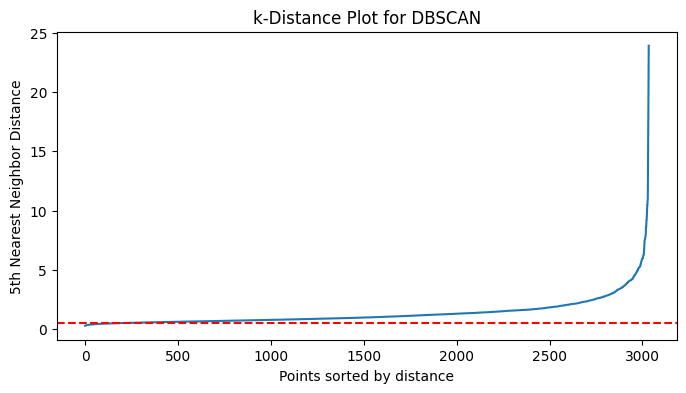

In [27]:
# Find optimal eps using k-distance plot
nn = NearestNeighbors(n_neighbors=5).fit(X)
distances, _ = nn.kneighbors(X)
distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("k-Distance Plot for DBSCAN")
plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

In [32]:
for test_eps in [0.5 , 2, 5, 10, 15, 20, 25]:
    db = DBSCAN(eps=test_eps, min_samples=5)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"eps={test_eps}: Clusters = {n_clusters}")

eps=0.5: Clusters = 43
eps=2: Clusters = 2
eps=5: Clusters = 6
eps=10: Clusters = 1
eps=15: Clusters = 1
eps=20: Clusters = 1
eps=25: Clusters = 1


In [33]:
dbscan = DBSCAN(eps=5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Add labels to PCA DataFrame
pca_df['DBSCAN_Cluster'] = dbscan_labels
print(f"DBSCAN found {len(np.unique(dbscan_labels))} clusters (including noise).")

DBSCAN found 7 clusters (including noise).


### **3-D Plots of K-Means and DBSCAN on PCA**

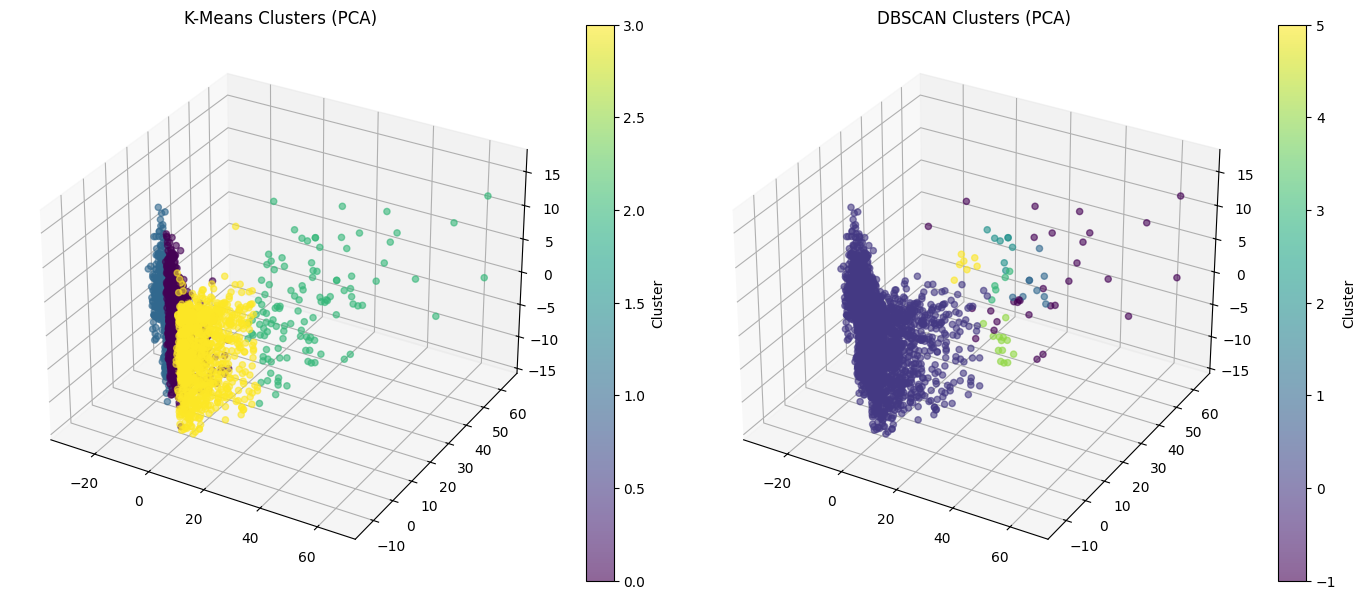

In [34]:
# K-Means Clusters
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
                      c=pca_df['KMeans_Cluster'], cmap='viridis', alpha=0.6)
ax1.set_title("K-Means Clusters (PCA)")
fig.colorbar(scatter1, ax=ax1, label='Cluster')

# DBSCAN Clusters
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
                      c=pca_df['DBSCAN_Cluster'], cmap='viridis', alpha=0.6)
ax2.set_title("DBSCAN Clusters (PCA)")
fig.colorbar(scatter2, ax=ax2, label='Cluster')
plt.tight_layout()
plt.show()

### **Evaluating clustering performance**

In [35]:
# K-Means Metrics
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_db = davies_bouldin_score(X, kmeans_labels)

# DBSCAN Metrics (ignore noise points for metrics)
valid_mask = dbscan_labels != -1  # Exclude noise
dbscan_silhouette = silhouette_score(X[valid_mask], dbscan_labels[valid_mask]) if sum(valid_mask) > 1 else -1
dbscan_db = davies_bouldin_score(X[valid_mask], dbscan_labels[valid_mask]) if sum(valid_mask) > 1 else -1

print("K-Means Metrics:")
print(f"- Inertia: {kmeans_inertia:.2f}")
print(f"- Silhouette Score: {kmeans_silhouette:.2f}")
print(f"- Davies-Bouldin Index: {kmeans_db:.2f}\n")

print("DBSCAN Metrics:")
print(f"- Silhouette Score: {dbscan_silhouette:.2f}")
print(f"- Davies-Bouldin Index: {dbscan_db:.2f}")

K-Means Metrics:
- Inertia: 191637.92
- Silhouette Score: 0.32
- Davies-Bouldin Index: 1.01

DBSCAN Metrics:
- Silhouette Score: 0.49
- Davies-Bouldin Index: 0.63


## **Comparison of K-Means and DBSCAN Performances**

- K-Means produced 4 moderately compact clusters on both PCA and t-SNE, with silhouette scores around 0.32-0.35.

- DBSCAN initially over-fragmented the data on t-SNE, resulting in 77 clusters, but when tuned on PCA (eps=5), it found 7 well-separated clusters.

- Final metrics show DBSCAN (PCA) outperforming K-Means in both silhouette score (0.49 vs 0.32) and Davies-Bouldin index (0.63 vs 1.01).

- Dimensionality reduction using PCA preserved global structure and enabled DBSCAN to outperform K-Means in clustering quality.

- Overall, DBSCAN on PCA gave the best clustering performance, provided proper tuning of the eps parameter.

## **Final Analysis**

**On Dimensionality Reduction:**

Dimensionality reduction played a crucial role in making clustering feasible and interpretable. Initially, the 256-dimensional feature space made it difficult to visualize or detect cluster structures. PCA helped reduce noise while retaining the global variance structure, making the data suitable for algorithms like K-Means and DBSCAN. t-SNE offered better visual separation but distorted the true distances and densities, which misled DBSCAN into over-segmentation. In contrast, PCA maintained metric integrity, which allowed DBSCAN to identify more meaningful density-based groupings after tuning.


**Clustering: K-Means vs DBSCAN:**

Among the clustering methods, DBSCAN ultimately outperformed K-Means when applied to PCA data. Its ability to detect clusters of varying shapes and ignore noise is especially valuable in real-world data like sound, which often contains outliers and non-uniform groupings. However, it required more careful parameter tuning. K-Means, while easier to apply, assumes spherical clusters and struggles with noise and irregular structures.


**Conclusion**

In real-world clustering tasks, the data is messy, high-dimensional, and non-uniform. There's no “one-size-fits-all” algorithm. Success depends on reducing the data meaningfully, choosing the right clustering approach, and carefully tuning parameters to handle the structure, noise, and complexity of real data.

